# Shear profile of A360 using Anacal - Manual

Prakruth Adari, Xiangchong Li, Anja von der Linden\
LSST Science Piplines version: Weekly 2025_14\
Container Size: large

This notebook is a condensed set of code to obtain a shear profile of Abell 360 using Anacal shear measurements. The main steps are:

- Loading the relevant object catalogs (all tracts and patches needed) using the butler
- Loading in Anacal catalogs
- Shear profile
- Mass Map

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import os, sys
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.stats as stats
from matplotlib import cm
from astropy.table import Table, join, vstack, hstack
from astropy.io import fits

# Familiar stack packages
from lsst.daf.butler import Butler
import lsst.geom as geom

import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils
cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

z_cl = 0.7

# source properties
# assume sources redshift following a the DESC SRD distribution. This will need updating.

z_distrib_func = utils.redshift_distributions.desc_srd  

# Compute first beta (e.g. eq(6) of WtGIII paper)
beta_kwargs = {
    "z_cl": z_cl,
    "z_inf": 10.0,
    "cosmo": cosmo,
    "z_distrib_func": z_distrib_func,
}
beta_s_mean = utils.compute_beta_s_mean_from_distribution(**beta_kwargs)
beta_s_square_mean = utils.compute_beta_s_square_mean_from_distribution(**beta_kwargs)

In [3]:
arcsec = 1/60**2
rng = np.random.default_rng()
omega_m = .31
omega_de= .69
omega_r = 0
H0 = 70 # km/s/Mpc
c = 3e5 # km/s

Hz = lambda z : c/(H0  * np.sqrt((omega_de + omega_m * (1+z)**3 + omega_r * (1+z)**4)))
chi_dl = lambda z, z0=0 : integrate.quad(Hz, z0, z)[0]
Da = lambda z : chi_dl(z)/(1+z)
beta_r = lambda zl, zs : integrate.quad(Hz, zl, zs)[0]/integrate.quad(Hz, 0, zs)[0]

In [4]:
# Load operation rehearsal data
# Can use obs_butler.registry.queryCollections to see available collections
obs_repo = '/repo/main'
obs_collection = 'LSSTComCam/runs/DRP/DP1/v29_0_0_rc5/DM-49865'
obs_butler = Butler(obs_repo, collections=obs_collection)
obs_registry = obs_butler.registry

t_skymap = obs_butler.get('skyMap', skymap='lsst_cells_v1')

In [104]:
cluster_coords = (59.487317, -49.000349)
ra_bcg = cluster_coords[0]
dec_bcg = cluster_coords[1]

# Looking for all patches in delta deg region around it
delta = 0.5
center = geom.SpherePoint(ra_bcg, dec_bcg, geom.degrees)
ra_min, ra_max = ra_bcg - delta, ra_bcg + delta
dec_min, dec_max = dec_bcg - delta, dec_bcg + delta

ra_range = (ra_min, ra_max)
dec_range = (dec_min, dec_max)
radec = [
    geom.SpherePoint(ra_range[0], dec_range[0], geom.degrees),
    geom.SpherePoint(ra_range[0], dec_range[1], geom.degrees),
    geom.SpherePoint(ra_range[1], dec_range[0], geom.degrees),
    geom.SpherePoint(ra_range[1], dec_range[1], geom.degrees)
]

tracts_and_patches = t_skymap.findTractPatchList(radec)

tp_dict = {}
for tract_num in np.arange(len(tracts_and_patches)):
    tract_info = tracts_and_patches[tract_num][0]
    tract_idx = tract_info.getId()
    # All the patches around the cluster
    patches = []
    for i,patch in enumerate(tracts_and_patches[tract_num][1]):
        patch_info = tracts_and_patches[tract_num][1][i]
        patch_idx = patch_info.sequential_index
        patches.append(patch_idx)
    tp_dict.update({tract_idx:patches})
print(tp_dict)
if False:
    # Flatten the dictionary into a list of rows
    rows = [(tract, patch) for tract, patches in tp_dict.items() for patch in patches]
    # Create DataFrame
    table = Table(rows=rows, names=["tract", "patch"])
    # Save to CSV
    csv_path = "patches2.csv"
    table.write(csv_path)

{2234: [60, 70, 80, 90, 61, 71, 81, 91, 62, 72, 82, 92, 63, 73, 83, 93, 64, 74, 84, 94], 2394: [2, 12, 22, 32, 42, 3, 13, 23, 33, 43, 4, 14, 24, 34, 44, 5, 15, 25, 35, 45, 6, 16, 26, 36, 46], 2235: [69, 79, 89, 99]}


In [105]:
anacal_tables = []
mag_zero = 31.4
version = "v7"
for tid in tp_dict.keys():
    patches = tp_dict[tid]
    for p in patches:
        fname = f'/sdf/data/rubin/shared/cluster_commissioning/AnaCal/catalog2_{version}/detect_{tid}-{p}.fits'
        fname2 = f'/sdf/data/rubin/shared/cluster_commissioning/AnaCal/catalog2_{version}/force_{tid}-{p}.fits'
        if os.path.isfile(fname) and os.path.isfile(fname2):
            ana_table = Table.read(fname)
            ana_table2 = Table.read(fname2)
            anacal_tables.append(hstack([ana_table, ana_table2]))
        else:
            print(fname)
anacal_table = vstack(anacal_tables)
anacal_table['mag'] = mag_zero - np.log10(anacal_table['flux'] ) *2.5
anacal_table['g_mag'] = mag_zero - np.log10(anacal_table['g_flux'] ) *2.5
anacal_table['r_mag'] = mag_zero - np.log10(anacal_table['r_flux'] ) *2.5
anacal_table['i_mag'] = mag_zero - np.log10(anacal_table['i_flux'] ) *2.5
anacal_table['z_mag'] = mag_zero - np.log10(anacal_table['z_flux'] ) *2.5

/sdf/data/rubin/shared/cluster_commissioning/AnaCal/catalog2_v7/detect_2234-60.fits
/sdf/data/rubin/shared/cluster_commissioning/AnaCal/catalog2_v7/detect_2234-70.fits
/sdf/data/rubin/shared/cluster_commissioning/AnaCal/catalog2_v7/detect_2234-80.fits
/sdf/data/rubin/shared/cluster_commissioning/AnaCal/catalog2_v7/detect_2234-90.fits
/sdf/data/rubin/shared/cluster_commissioning/AnaCal/catalog2_v7/detect_2234-61.fits
/sdf/data/rubin/shared/cluster_commissioning/AnaCal/catalog2_v7/detect_2234-71.fits
/sdf/data/rubin/shared/cluster_commissioning/AnaCal/catalog2_v7/detect_2234-81.fits
/sdf/data/rubin/shared/cluster_commissioning/AnaCal/catalog2_v7/detect_2234-91.fits
/sdf/data/rubin/shared/cluster_commissioning/AnaCal/catalog2_v7/detect_2234-62.fits
/sdf/data/rubin/shared/cluster_commissioning/AnaCal/catalog2_v7/detect_2234-72.fits
/sdf/data/rubin/shared/cluster_commissioning/AnaCal/catalog2_v7/detect_2234-82.fits
/sdf/data/rubin/shared/cluster_commissioning/AnaCal/catalog2_v7/detect_2234-

/lscratch/xiangchl/ipykernel_391244/4020660487.py:17: RuntimeWarning: invalid value encountered in log10
  anacal_table['g_mag'] = mag_zero - np.log10(anacal_table['g_flux'] ) *2.5
/lscratch/xiangchl/ipykernel_391244/4020660487.py:18: RuntimeWarning: invalid value encountered in log10
  anacal_table['r_mag'] = mag_zero - np.log10(anacal_table['r_flux'] ) *2.5
/lscratch/xiangchl/ipykernel_391244/4020660487.py:20: RuntimeWarning: invalid value encountered in log10
  anacal_table['z_mag'] = mag_zero - np.log10(anacal_table['z_flux'] ) *2.5


In [106]:
msk = np.logical_and.reduce((
    (anacal_table["wsel"] > 1e-5),
    (anacal_table["g_mag"] < 26.0),
    (anacal_table["r_mag"] < 25.0),
    (anacal_table["i_mag"] < 24.5),
    (anacal_table["z_mag"] < 26.0),
))
print(len(anacal_table))
print(np.sum((anacal_table["i_mag"] < 23.5)))
print(np.sum(anacal_table[anacal_table["i_mag"] < 23.5]["wsel"]))
anacal_table = anacal_table[msk]
ang_dist = np.sqrt(((anacal_table['ra'] - cluster_coords[0]) * np.cos(np.deg2rad(cluster_coords[1])))**2 + (anacal_table['dec'] - cluster_coords[1])**2) 

24000
12535
10611.02347656545


2394 14


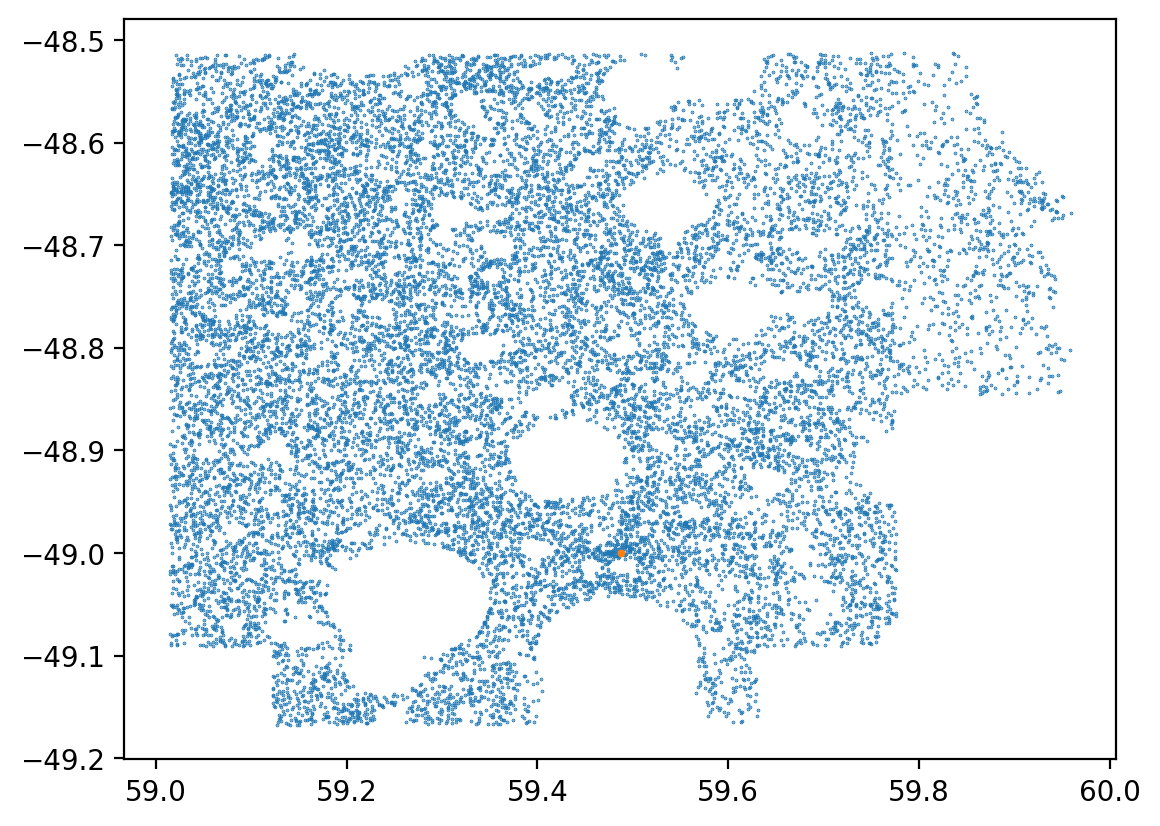

In [107]:
radec = [
    geom.SpherePoint(59.42, -48.92, geom.degrees),
]
tracts_and_patches = t_skymap.findTractPatchList(radec)
tp_dict = {}
for tract_num in np.arange(len(tracts_and_patches)):
    tract_info = tracts_and_patches[tract_num][0]
    tract_idx = tract_info.getId()
    # All the patches around the cluster
    patches = []
    for i,patch in enumerate(tracts_and_patches[tract_num][1]):
        patch_info = tracts_and_patches[tract_num][1][i]
        patch_idx = patch_info.sequential_index
        print(tract_idx, patch_idx)
plt.scatter(anacal_table["ra"], anacal_table["dec"], s=0.1)
plt.scatter(cluster_coords[0], cluster_coords[1], s=3.2)

In [108]:
c0 = 80.0
weights = {
    "g": 0.10110928,
    "r": 0.290752, 
    "i": 0.51740466 , 
    "z": 0.09073406,
}
m22c = np.zeros(len(anacal_table))
dm22c_dg1 = np.zeros(len(anacal_table))
m22s = np.zeros(len(anacal_table))
dm22s_dg2 = np.zeros(len(anacal_table))
m00 = np.zeros(len(anacal_table))
dm00_dg1 = np.zeros(len(anacal_table))
dm00_dg2 = np.zeros(len(anacal_table))
for band in ["g", "r", "i", "z"]:
    w = weights[band]
    m22c = m22c + anacal_table[f"{band}_fpfs1_m22c"] * w
    m22s = m22s + anacal_table[f"{band}_fpfs1_m22s"] * w
    m00 = m00 + anacal_table[f"{band}_fpfs1_m00"] * w
    dm22c_dg1 = dm22c_dg1 + anacal_table[f"{band}_fpfs1_dm22c_dg1"] * w
    dm22s_dg2 = dm22s_dg2 + anacal_table[f"{band}_fpfs1_dm22s_dg2"] * w
    dm00_dg1 = dm00_dg1 + anacal_table[f"{band}_fpfs1_dm00_dg1"] * w
    dm00_dg2 = dm00_dg2 + anacal_table[f"{band}_fpfs1_dm00_dg2"] * w
e1 = m22c / (m00 + c0) * anacal_table["wsel"]
e2 = m22s / (m00 + c0) * anacal_table["wsel"]
de1_dg1 = dm22c_dg1 / (m00 + c0) - m22c / (m00 + c0)**2.0 * dm00_dg1
de2_dg2 = dm22s_dg2 / (m00 + c0) - m22s / (m00 + c0)**2.0 * dm00_dg2
res = (
    de1_dg1 * anacal_table["wsel"] + anacal_table["dwsel_dg1"]* m22c / (m00 + c0) +
    de2_dg2 * anacal_table["wsel"] + anacal_table["dwsel_dg2"]* m22s / (m00 + c0)
) / 2.0

In [109]:
def fast_bootstrap_mean(data, n_resamples=2000, ci_level=0.95):
    n = len(data)
    means = np.empty(n_resamples)
    for i in range(n_resamples):
        sample = np.random.choice(data, size=n, replace=True)
        means[i] = np.mean(sample)
    alpha = 1.0 - ci_level
    lower = np.percentile(means, 100 * alpha / 2)
    upper = np.percentile(means, 100 * (1 - alpha / 2))
    return np.array([lower, upper])
    
def anacal_get_tang_cross(cluster, sky_dist, bins, R, ci_level=.95):
    nb = len(bins) - 1
    res_avg = np.zeros(nb)
    res_err = np.zeros((nb, 2))
    
    tang_avg = np.zeros(nb)
    cross_avg = np.zeros_like(tang_avg)

    tang_err = np.zeros((nb, 2))
    cross_err = np.zeros_like(tang_err)

    bin_rs = []
    R_correction2 = np.mean(R) 
    
    for i in range(nb):
        # bin_rs.append(bins[i])
        ndx_filt = (sky_dist > bins[i]) * (sky_dist < bins[i+1])
        bin_rs.append(np.where(ndx_filt)[0])
        if np.sum(ndx_filt) < 1:
            continue
            
        sample = cluster[ndx_filt]
        sample_t = sample.real
        sample_x = sample.imag

        sr = R[ndx_filt] 
        print(np.sum(ndx_filt))
        R_correction = np.mean(sr)
        ta = np.mean(sample_t)/R_correction2
        xa = np.mean(sample_x)/R_correction2
        
        re = fast_bootstrap_mean(sr, ci_level=ci_level, n_resamples=500)
        te = fast_bootstrap_mean(sample_t, ci_level=ci_level, n_resamples=500)
        xe = fast_bootstrap_mean(sample_x, ci_level=ci_level, n_resamples=500)
        
        res_avg[i] = R_correction
        res_err[i] = re
        tang_avg[i] = ta
        cross_avg[i] = xa
        tang_err[i] = te / R_correction2
        cross_err[i] = xe / R_correction2
    return tang_avg, cross_avg, tang_err, cross_err, bin_rs, res_avg, res_err

In [110]:
source_phi = np.arctan2(anacal_table['dec'] - cluster_coords[1], (cluster_coords[0] - anacal_table['ra'])*np.cos(np.deg2rad(cluster_coords[1])))
ang_dist = np.sqrt(((anacal_table['ra'] - cluster_coords[0]) * np.cos(np.deg2rad(cluster_coords[1])))**2 + (anacal_table['dec'] - cluster_coords[1])**2)
sky_distance = Da(z_cl) * ang_dist * (np.pi/180)

trial_shear = e1 + 1.j*e2
cl_shear = trial_shear * -1*np.exp(-2j*source_phi)

bins_mpc = clmm.make_bins(0.5,8,nbins=6, method='evenlog10width')
bin_mids = 1/2 * (bins_mpc[1:] + bins_mpc[:-1])
shear_cl = anacal_get_tang_cross(cl_shear, sky_distance, bins_mpc, res, ci_level=.68)

moo = clmm.Modeling(massdef="critical", delta_mdef=500, halo_profile_model="nfw")
moo.set_cosmo(cosmo)
moo.set_concentration(4)
moo.set_mass(3e14)

rproj = np.logspace(np.log10(0.5),np.log10(8.), 100)
gt_z = moo.eval_reduced_tangential_shear(
    rproj, z_cl, [beta_s_mean, beta_s_square_mean], z_src_info="beta", approx="order2"
)

149
359
606
1184
2884
5523


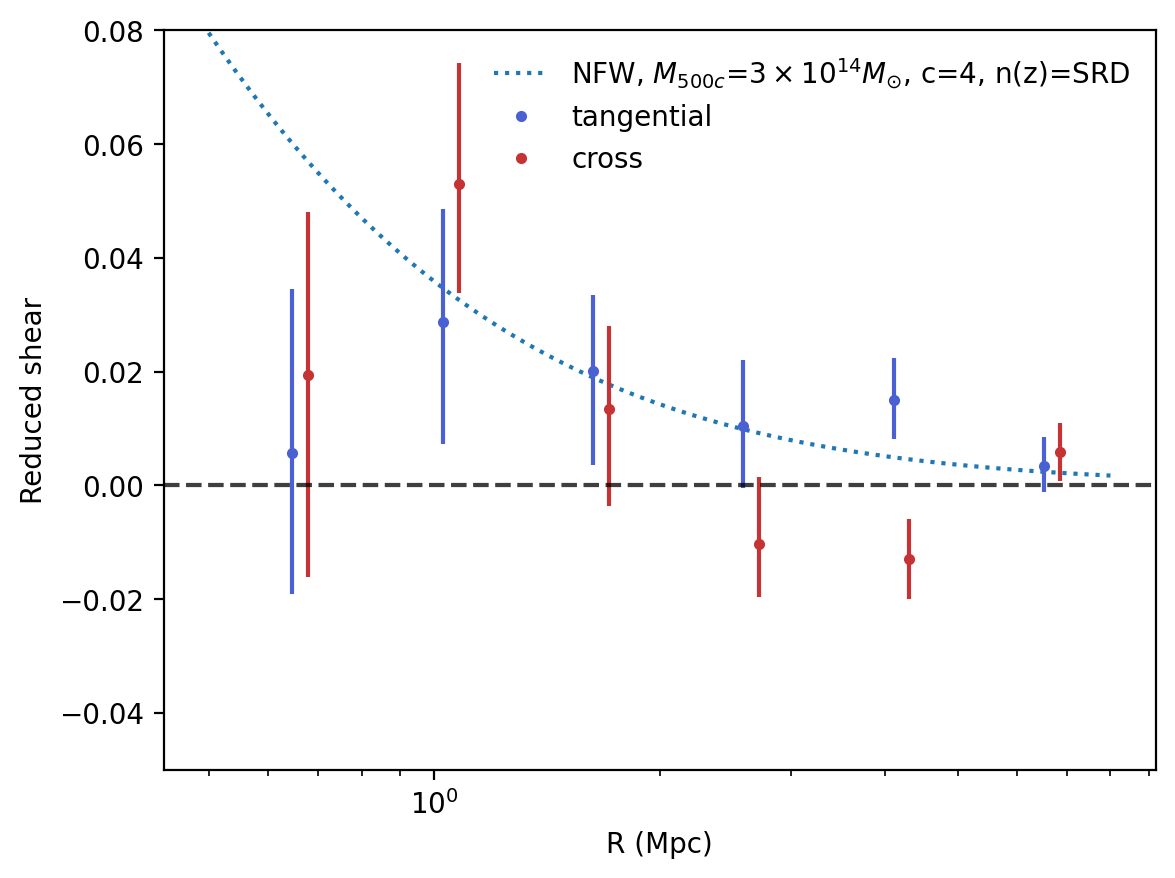

In [121]:
plt.close()
cmap = cm.coolwarm

plt.plot(rproj, gt_z, label=r'NFW, $M_{500c}$=$3 \times 10^{14} M_{\odot}$, c=4, n(z)=SRD', ls=':')
plt.plot(bin_mids, shear_cl[0], '.', label='tangential', color=cmap(.05))
plt.vlines(bin_mids, shear_cl[2][:,0], shear_cl[2][:,1], color=cmap(0.05))

plt.plot(1.05*bin_mids, shear_cl[1], '.', label='cross', color=cmap(.95))
plt.vlines(1.05*bin_mids, shear_cl[3][:,0], shear_cl[3][:,1], color=cmap(0.95))
plt.axhline(0, ls='--', color='k', alpha=.5)

plt.semilogx()
plt.axhline(0, ls='--', color='k', alpha=.5)
plt.ylim([-0.05,0.08])
plt.ylabel("Reduced shear")
plt.xlabel("R (Mpc)")
plt.legend(frameon=False, loc='upper right')

(0.02, 0.3)

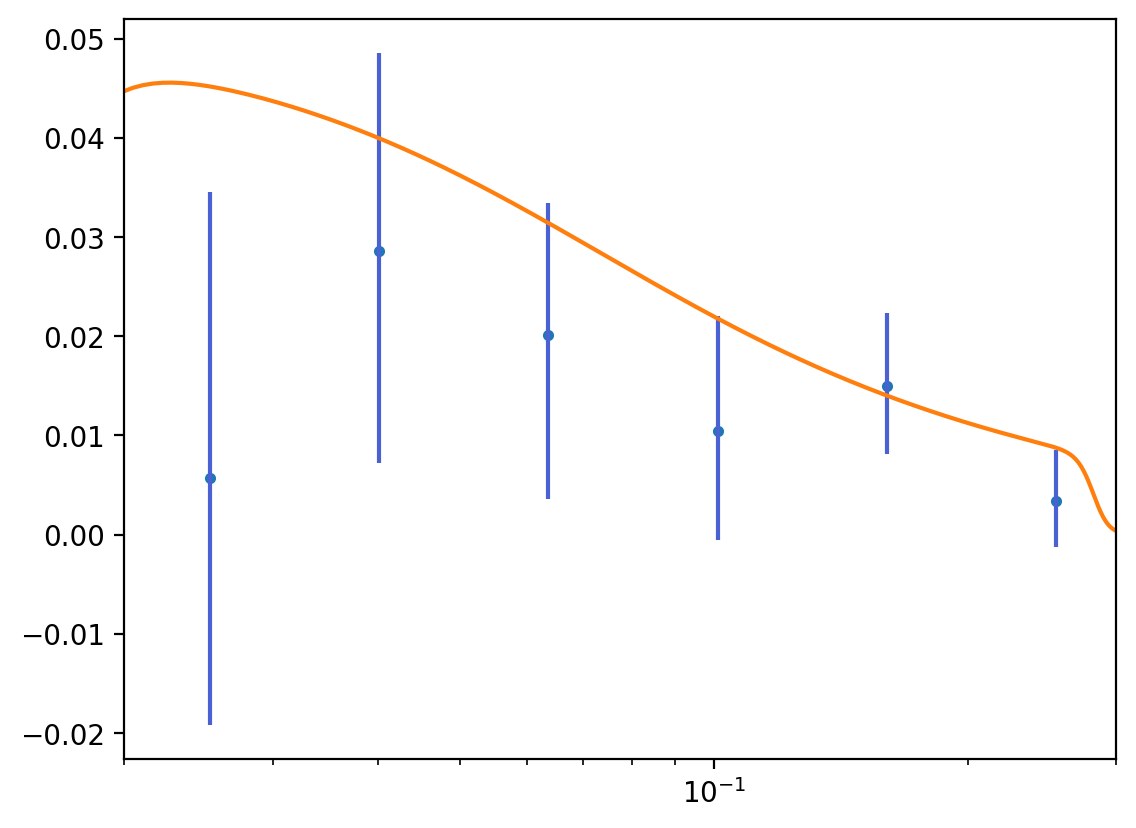

In [112]:
plt.plot(bin_mids / ( Da(z_cl) * (np.pi/180)), shear_cl[0], '.')
plt.vlines(bin_mids/ ( Da(z_cl) * (np.pi/180)), shear_cl[2][:,0], shear_cl[2][:,1], color=cmap(0.05))
x = np.linspace(0.01, 0.3, 500)
plt.plot(x, schirmer_filter(x, aperture_size=0.3, a=7, b=150) / 20)
plt.xscale("log")
plt.xlim(0.02, 0.3)

In [132]:
def schirmer_filter(radius,aperture_size=8000,x_cut=0.15,a=6,b=150,c=47,d=50,*_):
    '''
    The Schirmer Filter, a filter which is optimized for detecting NFW-like structures in shear-fields.
    
    Args:
        radius: Numpy array; an array of radii to evaluate the filter on
        aperture_size: float-like; the 'schirmer-radius' of the filter
        x_cut: float-like; specifies the filter-sloap and sets the characteristic-scale of the filter to x_cut*smoothing
    
    Returns:
        Q; Numpy array; an array containing the filter evaluated at each radius
    
    '''
    
    x = radius/aperture_size
    Q = ( 1/( 1 + np.exp(a - b*x) + np.exp(-c + d*x)) )*( np.tanh(x/x_cut)/(x/x_cut) )
    return Q
    
def compute_mass_map(x_grid,y_grid,x,y,g1,g2,weights,q_filter,filter_kwargs={}):
    '''
    This function computes the mass aperture-statistics at each point on a specified grid. Run quality-cuts, NaN filtering, etc. before this step!
    
    Args:
        x: Numpy array; an array of x-coordinates for each object
        y: Numpy array; an array of y-coordinates for each object
        x_grid: Numpy array; an NxM array of x-coordinates to sample the aperture-mass on
        y_grid: Numpy array; an NxM array of y-coordinates to sample the aperture-mass on
        g1; Numpy array; the shear g1 for each object
        g2; Numpy array; the shear g2 for each object
        weights: Numpy array; the weight for each object's shear
        q_filter; function; the filter-function used to compute Map
        kwargs; dict; kwargs passed to w_filter
    
    Returns:
        Map_E: Numpy array; an NxM array containing the E-mode aperture mass evaluated at each grid-point
        Map_B: Numpy array; an NxM array containing the B-mode aperture mass evaluated at each grid-point
        Map_V: Numpy array; an NxM array containing the variance in the aperture mass evaluated at each grid-point

    '''

    y_shape = len(y_grid[:,0])
    x_shape = len(x_grid[0,:])
    
    Map_E = np.zeros((y_shape,x_shape))
    Map_B = np.zeros((y_shape,x_shape))
    Map_V = np.zeros((y_shape,x_shape))
    
    if 'aperture_size' not in filter_kwargs:
        filter_area = np.pi * (0.55)**2
    else:
        filter_area = np.pi * filter_kwargs['aperture_size']**2
    
    comp_shear = g1 + 1j*g2
    g_mag = np.mean(g1**2 + g2**2) * np.ones_like(g1)
    print(np.sqrt(np.mean(g1**2 + g2**2) / 2.0))
    
    for i in range(y_shape):
        for j in range(x_shape):
            delta_x =  x - x_grid[i, j]
            delta_y =  y - y_grid[i, j]
            radius = np.sqrt(delta_x**2 + delta_y**2)
            theta = np.arctan2(delta_y,delta_x)
            rotated_shear = comp_shear * -1*np.exp(-2j*theta)
            g_T = rotated_shear.real
            g_X = rotated_shear.imag
            filter_values = q_filter(radius, a=7, b=150, **filter_kwargs)
            weight_sum = np.sum(weights)
            Map_E[i,j] = np.sum(filter_values*g_T*weights)*filter_area/weight_sum
            Map_B[i,j] = np.sum(filter_values*g_X*weights)*filter_area/weight_sum
            Map_V[i,j] = np.sum( (filter_values**2)*g_mag*(weights**2) )*(filter_area**2)/(2*(weight_sum**2))
    return Map_E, Map_B, Map_V

In [133]:
ra_bcg, dec_bcg = (cluster_coords[0], cluster_coords[1])
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord

# build wcs centered on BCG
flat_wcs = WCS(naxis=2)
crval_sky = [ra_bcg*u.deg,dec_bcg*u.deg]
flat_wcs.wcs.crval = [ra_bcg,dec_bcg]
flat_wcs.wcs.crpix = [0,0] # assign 0,0 to the center, shouldn't matter
flat_wcs.wcs.cdelt = [-0.2/3600,0.2/3600] # match angular resolution of LSST, 0.2"
flat_wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
flat_wcs.wcs.radesys = 'ICRS'
flat_wcs.wcs.equinox = 2000
flat_wcs.wcs.cd = [[-0.2/3600,0],[0,0.2/3600]]

# compute coords in the flat-sky
# coords = SkyCoord(ra=merged_cat_wl['coord_ra'][source_filt][to_use],dec=merged_cat_wl['coord_dec'][source_filt][to_use],unit='degree')
coords = SkyCoord(ra=anacal_table['ra'],dec=anacal_table['dec'],unit='degree')
x,y = skycoord_to_pixel(coords,wcs=flat_wcs)

# scale these up to units of degrees to match mass_map spacing and make writing the aperture easier
x = x * 0.2/3600
y = y * 0.2/3600

# for now I'll weight everything uniformly
weights = np.ones(len(x))

# Define an NxN grid centered on the cluster
# Spans 1-deg centered at the BCG
# scale so that its in pixel coordinates for computing
N = 121
rr = 0.12

mid_x = 0
mid_y = 0

x_grid_samples = np.linspace(mid_x-rr,mid_x+rr,N)
y_grid_samples = np.linspace(mid_y-rr,mid_y+rr,N)
y_grid,x_grid = np.meshgrid(y_grid_samples,x_grid_samples)

In [134]:
# Using a global R for the first try:
global_R = np.mean(res)
print(global_R)
weights = np.ones(len(x))
g1 = e1 / global_R
g2 = e2 / global_R

0.24768549899210263


In [135]:
e_ap,b_ap,v_ap = compute_mass_map(
    x_grid,y_grid,
    x,y,
    g1,g2,
    weights,
    schirmer_filter,
    filter_kwargs={'aperture_size':0.3}
)

0.3805217106733143


In [136]:
(0.30 / 0.38) ** 2.0

0.6232686980609419

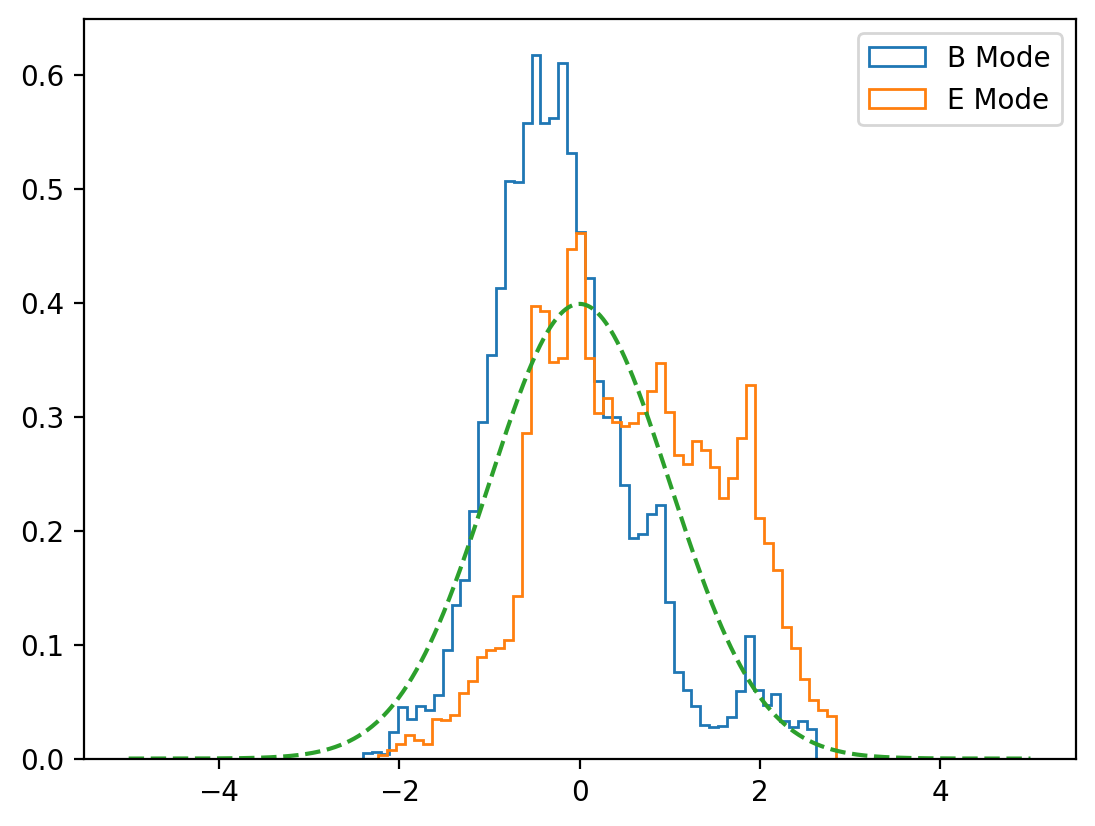

In [126]:
sky_box = np.array([[x_grid.max(), x_grid.min()],[y_grid.min(), y_grid.max()]])
test_xs = np.linspace(-5, 5, num=1001)
standard = stats.norm(0, 1)
normal_dist = standard.pdf(test_xs)
plt.hist((b_ap/np.sqrt(np.mean(v_ap))).flatten(), bins=51, label='B Mode', histtype='step', density=True)
plt.hist((e_ap/np.sqrt(np.mean(v_ap))).flatten(), bins=51, label='E Mode', histtype='step', density=True)
plt.plot(test_xs, normal_dist, '--')
plt.legend();

[2.84467786]


Text(0.05, 0.5, 'DEC')

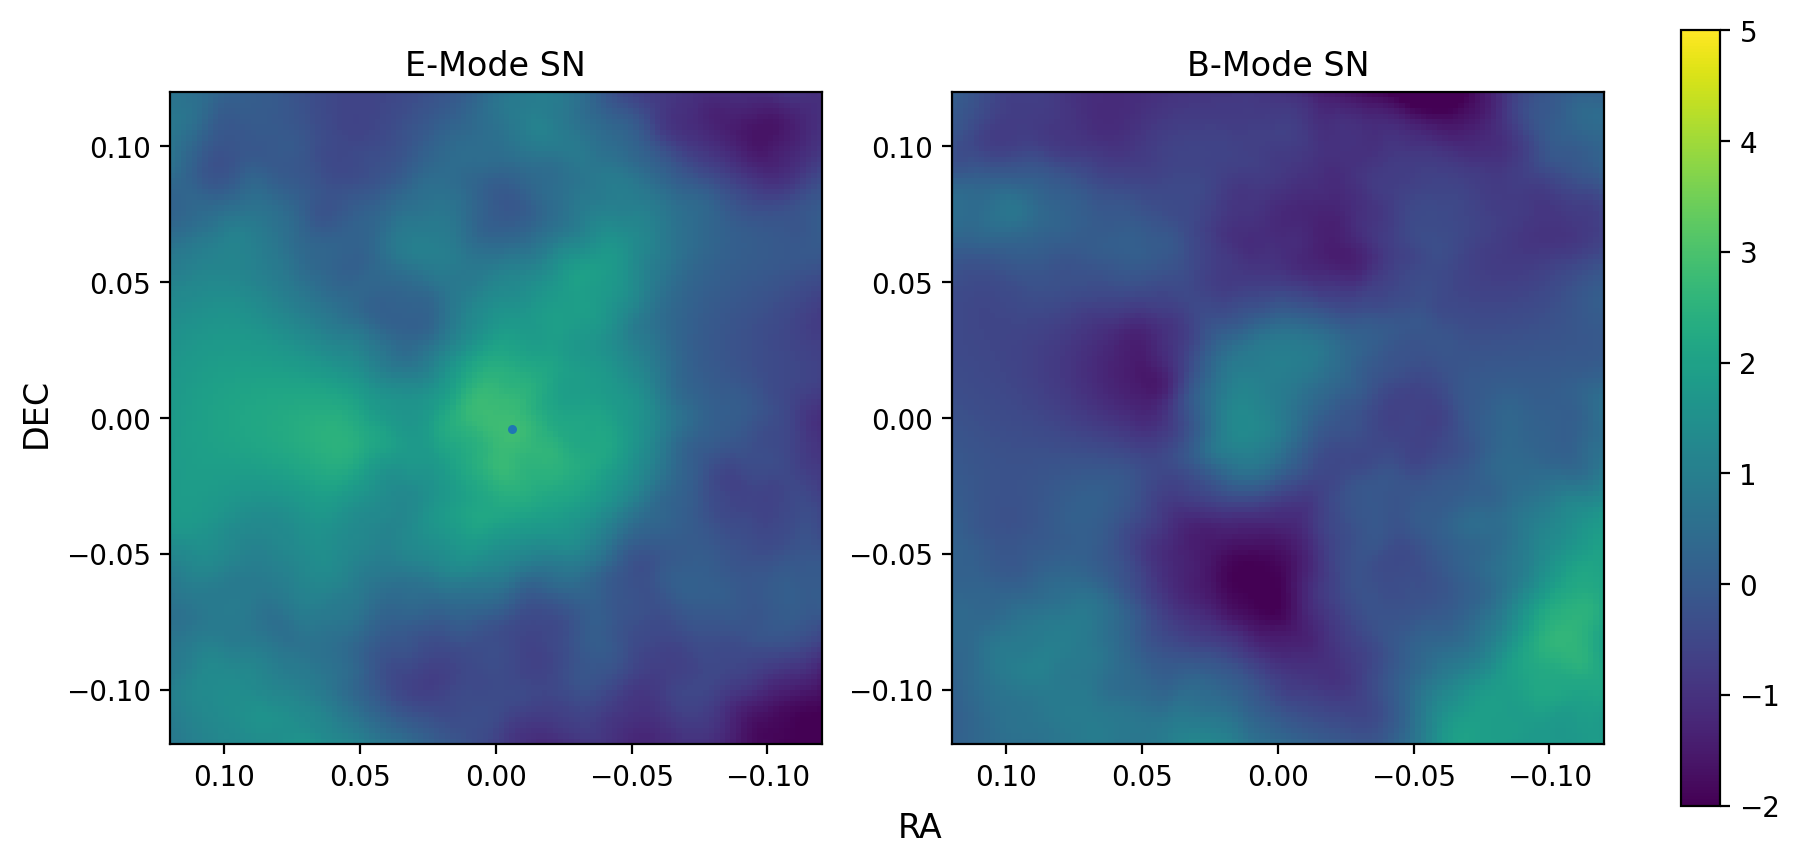

In [127]:
fig, axs = plt.subplots(ncols=2,figsize=(10,6))

ax = axs[0]
ax.set_title('E-Mode SN')
extent=(rr, -rr, -rr, rr)
MapE = ax.imshow(
    e_ap /np.sqrt(np.mean(v_ap)),
    vmin=-2, vmax=5,
    origin='lower', 
    extent=extent,
)
y , x =np.where(e_ap /np.sqrt(np.mean(v_ap)) == np.max(e_ap /np.sqrt(np.mean(v_ap))))
print((e_ap /np.sqrt(np.mean(v_ap)))[y, x])
x_vals = np.linspace(extent[0], extent[1], N)
y_vals = np.linspace(extent[2], extent[3], N)
x_coord = x_vals[x]
y_coord = y_vals[y]
ax.scatter(x_coord, y_coord, s=5.0)

ax = axs[1]
ax.set_title('B-Mode SN')
MapB = ax.imshow(
    b_ap/np.sqrt(np.mean(v_ap)),
    vmin=-2, vmax=5,
    origin='lower', 
    extent=extent
)

# for xx in axs:
#     xx.plot(ra_bcg, dec_bcg, 'rx')
cbar = fig.colorbar(MapE, ax=axs,fraction=0.025)

fig.supxlabel("RA", y=0.14)
fig.supylabel("DEC", x=0.05)

In [119]:
np.max(b_ap /np.sqrt(np.mean(v_ap)))

2.62120853224762

In [120]:
np.min(b_ap /np.sqrt(np.mean(v_ap)))

-2.405634796273